# Notebook to evalute each Model in more detail

In [4]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# to enable local imports
module_path = os.path.abspath('../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

    
from pathlib import Path
try:
    try:
        json_path = (Path(os.getenv('LOCALAPPDATA'))/'Dropbox'/'info.json').resolve()
    except FileNotFoundError:
        json_path = (Path(os.getenv('APPDATA'))/'Dropbox'/'info.json').resolve()

    with open(str(json_path)) as f:
        j = json.load(f)

    personal_dbox_path = Path(j['personal']['path'])
    # Save the images directly into the dropbox where the overleaf document is stored
    IMAGES_PATH = os.path.join(str(personal_dbox_path), 'Apps', 'Overleaf', 'Masterthesis_Paper', 'images')

except Exception as e:
    IMAGES_PATH = "../images"
    print(e)
    
print("Saving images to: {}".format(IMAGES_PATH))
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

from machine_learning_load_data import loadOnlineEEGdata
from utils import loadTargetLabelsTxt

D:\Masterthesis\thesis_eeg\code
Saving images to: D:\Dropbox\Apps\Overleaf\Masterthesis_Paper\images


In [5]:
# Load some online EEG Data

##################
# online eeg data
##################
eegData, freqData, entropyData = loadOnlineEEGdata(dirPath='../../EEG_Data/eeg_data_online', splitData=True)

X_train_eeg, y_train_eeg, X_test_eeg, y_test_eeg = eegData
X_train_freq, y_train_freq, X_test_freq, y_test_freq = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
X_train_freq = X_train_freq.reshape(X_train_freq.shape[0], X_train_freq.shape[2])
X_test_freq = X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])

targetLabelsDict = loadTargetLabelsTxt(filePath='../../EEG_Data/eeg_data_online/target_labels.txt')
targetNames = ['Fatigue ({})'.format(targetLabelsDict['FATIGUE']),
               'Normal ({})'.format(targetLabelsDict['NORMAL'])]


##################
# experiment data
##################
eegData_exp, freqData_exp, entropyData_exp = loadOnlineEEGdata(dirPath='../../EEG_Data/muse_data', splitData=True)

X_train_eeg_exp, y_train_eeg_exp, X_test_eeg_exp, y_test_eeg_exp = eegData_exp
X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp = freqData_exp
X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp = entropyData_exp

# reshape
X_train_freq_exp = X_train_freq_exp.reshape(X_train_freq_exp.shape[0], X_train_freq_exp.shape[2])
X_test_freq_exp = X_test_freq_exp.reshape(X_test_freq_exp.shape[0], X_test_freq_exp.shape[2])

X_train_entropy_exp = X_train_entropy_exp.reshape(X_train_entropy_exp.shape[0], X_train_entropy_exp.shape[2])
X_test_entropy_exp = X_test_entropy_exp.reshape(X_test_entropy_exp.shape[0], X_test_entropy_exp.shape[2])

targetLabelsDict_exp = loadTargetLabelsTxt(filePath='../../EEG_Data/muse_data/target_labels.txt')
targetNames_exp = ['AWAKE ({})'.format(targetLabelsDict_exp['AWAKE']),
               'FATIGUE ({})'.format(targetLabelsDict_exp['FATIGUE'])]

Loading Online EEG Data from ../../EEG_Data/eeg_data_online ...
EEG Data Shape:
(5024, 512, 40) (5024,) (2154, 512, 40) (2154,)
Freq Data Shape:
(1008, 1, 1200) (1008,) (432, 1, 1200) (432,)
Entropy Data Shape:
(5024, 1, 200) (5024,) (2154, 1, 200) (2154,)
Loading Online EEG Data from ../../EEG_Data/muse_data ...
EEG Data Shape:
(3306, 512, 4) (3306,) (1418, 512, 4) (1418,)
Freq Data Shape:
(665, 1, 120) (665,) (285, 1, 120) (285,)
Entropy Data Shape:
(3306, 1, 20) (3306,) (1418, 1, 20) (1418,)


## Functions to evalute a Model (maybe move into a .py file)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score) 

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)   

def plot_precision_vs_recall(precisions, recalls):
    plt.title("Precision versus recall")
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.title("Precision versus recall - Threshold Plot")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)      


# Create a model
def evaluateModel(model,X_train, y_train, X_test=None, y_test=None, kfoldTimes=8, n_jobs=-1, scoring_acc = False):
    
    print("Model: {}".format(model))
    
    # generate cross val score
    kfoldTimes = kfoldTimes
    print("Calculating cross val scores...")
    
    if scoring_acc:
        accuaries = cross_val_score(model, X_train, y_train, cv=kfoldTimes, scoring='accuracy', n_jobs=n_jobs)
    else:
        accuaries = cross_val_score(model, X_train, y_train, cv=kfoldTimes, scoring=f1_scorer, n_jobs=n_jobs)
    print("Cross val scores (Accuracies):")
    for i in range(0, len(accuaries)):
        print(" Fold {fold}: {acc}".format(fold=i+1, acc=accuaries[i]))

    # make predictions with the model
    print("\nCaclulating cross val predictions...")
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=kfoldTimes, n_jobs=n_jobs)


    svm_confusionMatrix = confusion_matrix(y_train, y_train_pred)
    print("""\nConfusion Matrix\n------------------------
    True Negative:   {tn} - False Positive: {fp}
    False Negatives: {fn} - True positive:  {tp}""".format(tn=svm_confusionMatrix[0][0],
                                                           fp=svm_confusionMatrix[0][1],
                                                           fn=svm_confusionMatrix[1][0],
                                                           tp=svm_confusionMatrix[1][1]))

    print("----------------------")
    print("Precision: {} ".format(precision_score(y_train, y_train_pred)))
    print("Recall:    {}".format(recall_score(y_train, y_train_pred)))
    print("F1 Score:  {}".format(f1_score(y_train, y_train_pred)))
    
    # Calculate and plot the precion-recall tradeoff
    model.fit(X_train, y_train)
    y_score = model.decision_function(X_train)
    average_precision = average_precision_score(y_train, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    disp = plot_precision_recall_curve(model, X_train, y_train)
    disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    
    # Calculate and plot precision vs. recall - threshold plot
    y_scores_dec_func = cross_val_predict(model, X_train, y_train, cv=kfoldTimes, method="decision_function", n_jobs=n_jobs)
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_dec_func)
    
    plt.figure(figsize=(8, 4))
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    
    # Plot precision vs. recall directly against each other
    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    
    
    # Calculate and plot the ROC Curve
    fpr, tpr, thresholds = roc_curve(y_train, y_scores_dec_func)
    plt.figure(figsize=(8, 6)) 
    plot_roc_curve(fpr, tpr)
    
    
    # Compare to another model
    from sklearn.ensemble import RandomForestClassifier
    forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=kfoldTimes, method="predict_proba", n_jobs=n_jobs)
    
    y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
    fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, "b:", linewidth=2, label="SVM")
    plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=16)


In [8]:
# good model
goodModel = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Evaluate SVM

Model: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.7466666666666667
 Fold 2: 0.7631578947368421
 Fold 3: 0.8437499999999999
 Fold 4: 0.9142857142857143
 Fold 5: 0.8115942028985507
 Fold 6: 0.76
 Fold 7: 0.5862068965517242
 Fold 8: 1.0

Caclulating cross val predictions...

Confusion Matrix
------------------------
    True Negative:   314 - False Positive: 50
    False Negatives: 64 - True positive:  237
----------------------
Precision: 0.8257839721254355 
Recall:    0.7873754152823921
F1 Score:  0.806122448979592
Average precision-recall score: 1.00


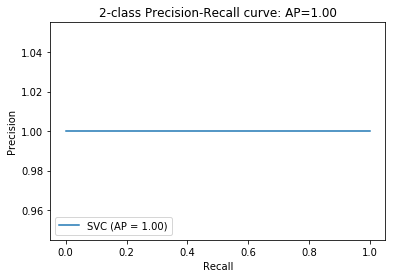

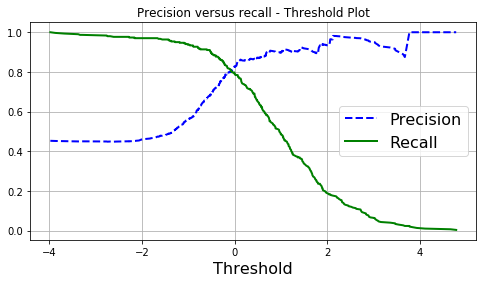

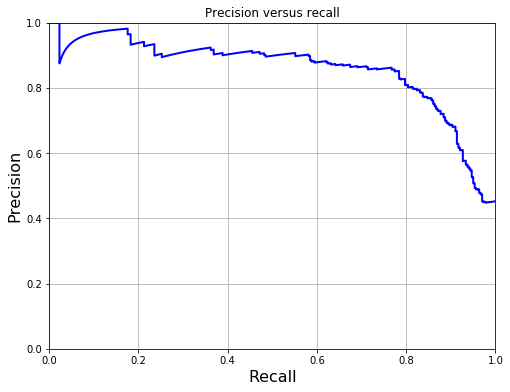

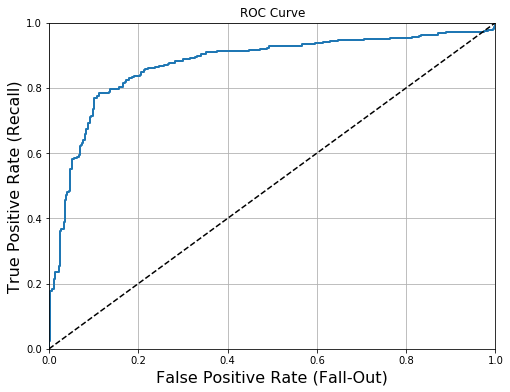

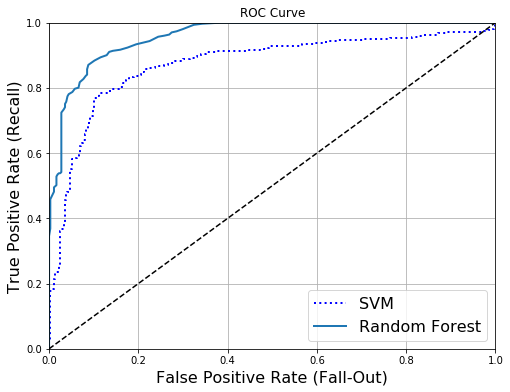

In [4]:
#simpleModel = svm.SVC(kernel='rbf', gamma=0.3, C=1.0)

evaluateModel(model=goodModel,
              X_train=X_train_freq_exp,
              y_train=y_train_freq_exp,
              X_test=X_test_freq_exp,
              y_test=y_test_freq_exp)




Model: SVC(degree=5, kernel='poly')
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.7738095238095238
 Fold 2: 0.7831325301204819
 Fold 3: 0.8795180722891566
 Fold 4: 0.927710843373494
 Fold 5: 0.8433734939759037
 Fold 6: 0.7108433734939759
 Fold 7: 0.7108433734939759
 Fold 8: 1.0

Caclulating cross val predictions...

Confusion Matrix
------------------------
    True Negative:   314 - False Positive: 50
    False Negatives: 64 - True positive:  237
----------------------
Precision: 0.8257839721254355 
Recall:    0.7873754152823921
F1 Score:  0.806122448979592
Average precision-recall score: 1.00


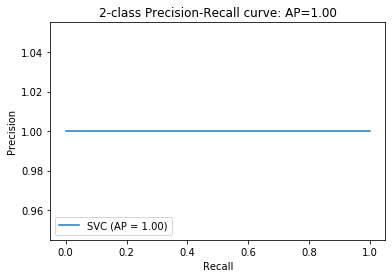

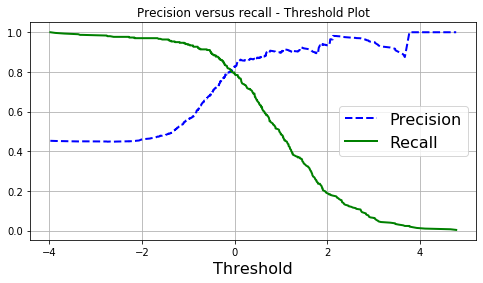

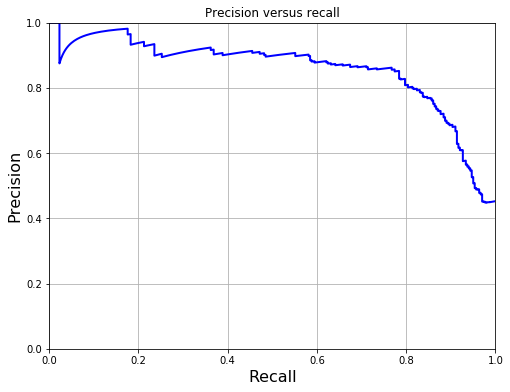

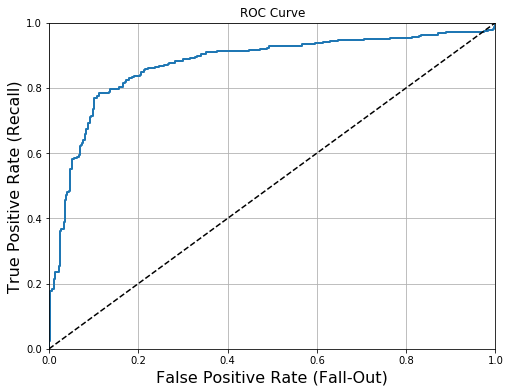

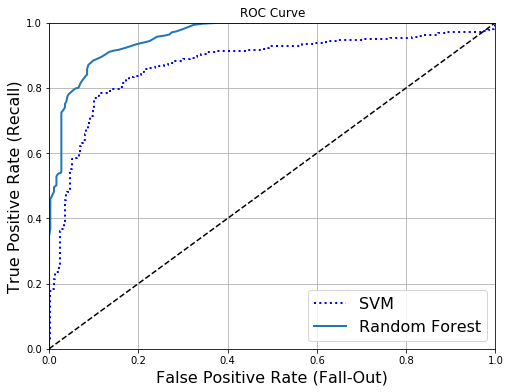

In [11]:
# scoring = accuarcy
evaluateModel(model=goodModel,
              X_train=X_train_freq_exp,
              y_train=y_train_freq_exp,
              X_test=X_test_freq_exp,
              y_test=y_test_freq_exp,
              scoring_acc=True)

Model: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.5957446808510638
 Fold 2: 0.7002398081534772
 Fold 3: 0.7353760445682451
 Fold 4: 0.7109974424552429
 Fold 5: 0.735632183908046
 Fold 6: 0.8090452261306533
 Fold 7: 0.7210031347962381
 Fold 8: 0.6991404011461317

Caclulating cross val predictions...

Confusion Matrix
------------------------
    True Negative:   1349 - False Positive: 461
    False Negatives: 409 - True positive:  1087
----------------------
Precision: 0.7021963824289406 
Recall:    0.7266042780748663
F1 Score:  0.7141918528252299
Average precision-recall score: 0.99


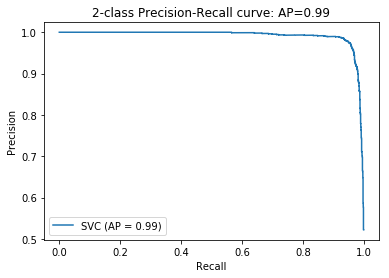

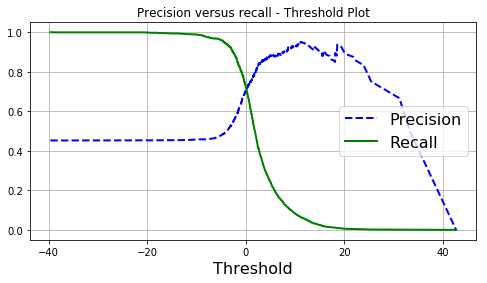

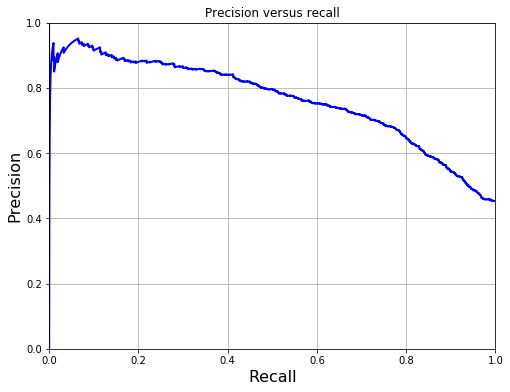

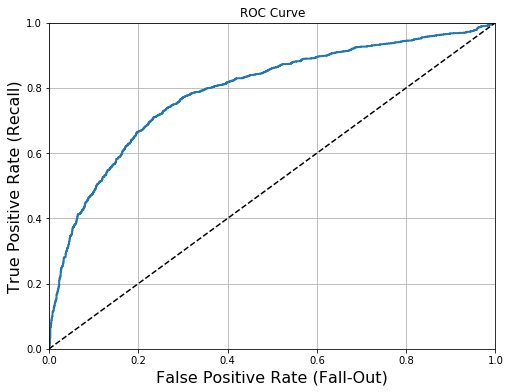

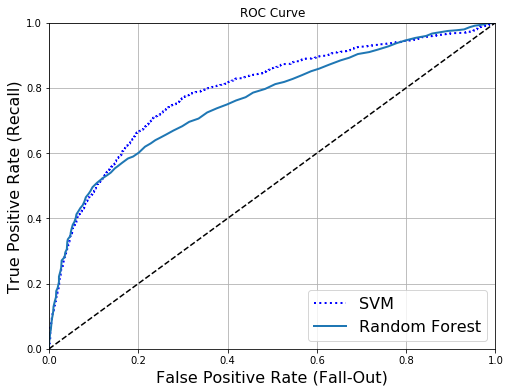

In [5]:
evaluateModel(model=goodModel,
              X_train=X_train_entropy_exp,
              y_train=y_train_entropy_exp,
              X_test=X_test_entropy_exp,
              y_test=y_test_entropy_exp)